Prediction of Natural gas price

In [5]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [6]:
ng_df = pd.read_csv('Nat_Gas.csv')
ng_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


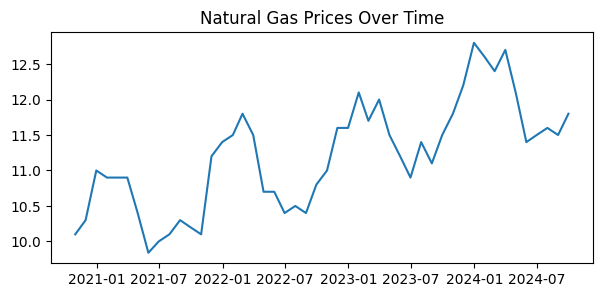

In [ ]:
ng_df['Dates'] = pd.to_datetime(ng_df['Dates'], format='%m/%d/%y')
ng_df.set_index('Dates', inplace=True)

plt.figure(figsize=(7,3))
plt.plot(ng_df['Prices'])
plt.title('Natural Gas Prices Over Time')
plt.show()

We use SARIMA model to predict natural gas prices.

A clear rising trend can be observed so the time series is not stationary. We can also perform the following dickey-fuller test to verify it.

In [ ]:
def stationarity_test(ts):
    df_test = adfuller(ts)
    adf = df_test[0]
    pvalue = df_test[1]
    critical_value = df_test[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The time series is stationary')
    else:
        print('The time series is NOT stationary')
    return df_test
stationarity_test(ng_df['Prices'])


The time series is NOT stationary


(0.21807686169999987,
 0.9732574388448693,
 10,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 10.198475035166425)

STL decomposition


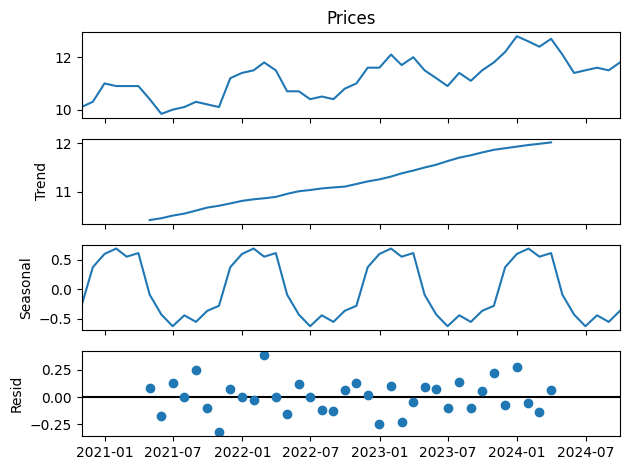

In [ ]:
def decompose_series(data, model='additive', period=None):
    if period is None:
        period = pd.infer_freq(data.index)
        
    if period is None:
        raise ValueError("Period could not be inferred. Please specify it explicitly.")

    decomposition = seasonal_decompose(data, model=model, period=period)
    return decomposition


decomposition = decompose_series(ng_df['Prices'], model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
plt.show()

Next we search for the best parameters p,d,q,P,D,Q,s in SARIMA model and fit the model.


In [ ]:
model = pm.auto_arima(ng_df["Prices"], seasonal=True, m=12, 
                      trace=True, error_action='ignore', suppress_warnings=True,
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=36.632, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=39.688, Time=0.33 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=40.128, Time=0.60 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.232, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=35.994, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953,

C:\Users\yflauag\AppData\Local\Temp\ipykernel_17072\3417305950.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]


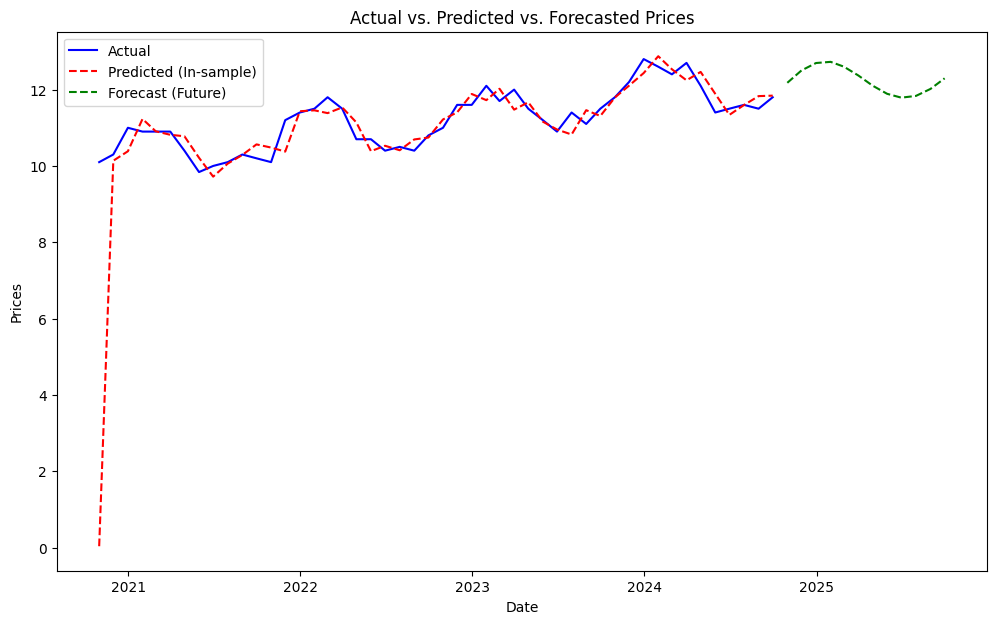

In [ ]:
# Generate future predictions
# Assuming monthly data and forecasting one year ahead
n_periods = 12
future_forecast = model.predict(n_periods=n_periods)

# Creating a date range for the future forecasts which extends from the last date in the original dataset
last_date = ng_df.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]

# Combine the original and future data for a comprehensive view
full_dates = ng_df.index.append(future_dates)  # Full date range
full_predictions = pd.concat([pd.Series(model.predict_in_sample()), pd.Series(future_forecast, index=future_dates)])


fig, ax = plt.subplots(figsize=(12, 7))

# Actual data
ax.plot(ng_df.index, ng_df['Prices'], color='blue', label='Actual')

# Predicted data (in-sample)
ax.plot(ng_df.index, model.predict_in_sample(), color='red', linestyle='--', label='Predicted (In-sample)')

# Future predictions
ax.plot(future_dates, future_forecast, color='green', linestyle='--', label='Forecast (Future)')


ax.set_title('Actual vs. Predicted vs. Forecasted Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
ax.legend()

plt.show()

In [ ]:
def estimate_price(date):
    if date in ng_df.index:
        return ng_df.loc[date, 'Prices']
    elif date > ng_df.index[-1]:
        future_index = pd.date_range(start=last_date, periods=13, freq='M')[1:]
        if date in future_index:
            return future_predictions[future_index.get_loc(date)]
    else:
        return model.predict(start=date, end=date)[0]

# Example usage
input_date = pd.to_datetime('2025-9-30')
estimated_price = estimate_price(input_date)
print(f"Estimated price for {input_date.date()}: {estimated_price:.2f}")

Estimated price for 2025-09-30: 12.30


C:\Users\yflauag\AppData\Local\Temp\ipykernel_17072\3821687917.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date, periods=13, freq='M')[1:]
C:\Users\yflauag\AppData\Local\Temp\ipykernel_17072\3821687917.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return future_predictions[future_index.get_loc(date)]
